# Mortgage Lending Fair Feature Selection

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import datetime
from datetime import date
#import imblearn
import xgboost as xgb
#import fairfs
import probatus
import shap
import aif360

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import metrics, model_selection, pipeline, preprocessing
from sklearn import linear_model, naive_bayes, tree
from statistics import mean
from mlxtend.feature_selection import SequentialFeatureSelector
#from fairfs import unfairness_metrics
from probatus.feature_elimination import ShapRFECV
from probatus.feature_elimination import EarlyStoppingShapRFECV
from numpy import sqrt
from numpy import argmax

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


#### 1. HMDA Mortgage Lending Data
### Data Source: 
*Source: https://ffiec.cfpb.gov/documentation/2019/*

In [2]:
# Load HMDA data
#data = pd.read_csv(r'C:\Users\arinath\Documents\Project Documents\TAI\XAI WP POC\2019_public_lar_one_year.csv', nrows=1500000)
data = pd.read_csv(r'C:\Users\arinath\Documents\Project Documents\TAI\XAI WP POC\2019_public_lar_one_year.csv', nrows=200000)
data.info()

Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 99 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   activity_year                             200000 non-null  int64  
 1   lei                                       200000 non-null  object 
 2   derived_msa_md                            200000 non-null  int64  
 3   state_code                                192903 non-null  object 
 4   county_code                               190702 non-null  float64
 5   census_tract                              190603 non-null  float64
 6   conforming_loan_limit                     198383 non-null  object 
 7   derived_loan_product_type                 200000 non-null  object 
 8   derived_dwelling_category                 200000 non-null  object 
 9   derived_ethnicity                         200000 non-null  object 
 10  derived_race        

In [3]:
data['action_taken'].unique()

array([1, 4, 5, 3, 2, 6, 8, 7], dtype=int64)

In [4]:
data.drop_duplicates()

,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason_2,denial_reason_3,denial_reason_4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2019,549300YOEBGKPKU43Q28,45300,FL,12057.0,1.205701e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,9537,55.65,66900,143.0,2099,3624,11
1,2019,549300YOEBGKPKU43Q28,19660,FL,12127.0,1.212708e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,6147,11.88,59500,155.0,1878,2149,13
2,2019,549300YOEBGKPKU43Q28,25540,CT,9003.0,9.003476e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4409,18.78,98400,86.0,1236,1738,57
3,2019,549300YOEBGKPKU43Q28,38340,MA,25003.0,2.500393e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,1514,9.05,81700,97.0,580,744,42
4,2019,549300YOEBGKPKU43Q28,15764,MA,25017.0,2.501733e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,7314,15.37,115500,115.0,1773,2035,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,2019,549300UG7QXKM7KGV847,10740,NM,35001.0,3.500100e+10,C,FHA:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,...,NaN,NaN,NaN,7184,94.68,65700,57.0,1741,2421,47
199996,2019,549300UG7QXKM7KGV847,99999,NC,37163.0,3.716397e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,6267,48.99,51600,78.0,1601,2438,35
199997,2019,549300UG7QXKM7KGV847,49660,PA,42085.0,4.208503e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3085,4.73,61300,99.0,785,1258,69
199998,2019,549300UG7QXKM7KGV847,12620,ME,23019.0,2.301902e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,2769,6.43,66600,104.0,920,1373,33


In [5]:
data.derived_race.unique()

array(['White', 'Race Not Available', 'Asian',
       'Black or African American', 'Joint',
       'American Indian or Alaska Native',
       'Native Hawaiian or Other Pacific Islander', 'Free Form Text Only',
       '2 or more minority races'], dtype=object)

In [6]:
data.derived_ethnicity.unique()

array(['Not Hispanic or Latino', 'Ethnicity Not Available',
       'Hispanic or Latino', 'Joint', 'Free Form Text Only'], dtype=object)

In [7]:
data.derived_sex.unique()

array(['Female', 'Sex Not Available', 'Joint', 'Male'], dtype=object)

#### Checking for duplicates where same loan application with diff. approval status are present

In [8]:
df_action_taken = data.groupby(['lei','derived_msa_md',
'state_code',
'county_code',
'census_tract',
'conforming_loan_limit',
'derived_loan_product_type',
'derived_dwelling_category',
'derived_ethnicity', 'derived_race', 'derived_sex',
'purchaser_type','loan_type','loan_purpose','lien_status', 'reverse_mortgage','open_end_line_of_credit','business_or_commercial_purpose',
                'loan_amount','total_loan_costs','income','debt_to_income_ratio','total_units', 'property_value'
                               ])['action_taken'].size().reset_index(name='count')
                               
                               #])['action_taken'].apply(lambda x: (x>1).sum()).reset_index(name='count')
#df_action_taken['action_taken'].unique

In [9]:
df_action_taken_1 = df_action_taken[df_action_taken['count']>1].sort_values(by=['lei','derived_msa_md',
'state_code',
'county_code',
'census_tract',
'conforming_loan_limit',
'derived_loan_product_type',
'derived_dwelling_category',
'derived_ethnicity', 'derived_race', 'derived_sex',
'purchaser_type','loan_type','loan_purpose','lien_status', 'reverse_mortgage','open_end_line_of_credit','business_or_commercial_purpose',
'loan_amount','total_loan_costs','income','debt_to_income_ratio','total_units', 'property_value'], ascending=False)
df_action_taken_1

,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,derived_race,...,reverse_mortgage,open_end_line_of_credit,business_or_commercial_purpose,loan_amount,total_loan_costs,income,debt_to_income_ratio,total_units,property_value,count
75941,549300YOEBGKPKU43Q28,22744,FL,12011.0,1.201106e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,Race Not Available,...,1111,1111,1111,375000,Exempt,135.0,Exempt,1,Exempt,2
73917,549300WMQ4WI6QXK7803,16740,NC,37119.0,3.711901e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,American Indian or Alaska Native,...,1111,1111,1111,325000,Exempt,230.0,Exempt,1,Exempt,2
73912,549300WMQ4WI6QXK7803,16740,NC,37119.0,3.711901e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,...,1111,1111,1111,215000,Exempt,91.0,Exempt,1,Exempt,2
43379,549300BNZVNK1XN85P72,99999,IA,19167.0,1.916707e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,...,1111,1111,1111,105000,Exempt,217.0,Exempt,1,Exempt,2
43367,549300BNZVNK1XN85P72,99999,IA,19167.0,1.916707e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,...,1111,1111,1111,165000,Exempt,58.0,Exempt,1,Exempt,2
43197,549300BNZVNK1XN85P72,99999,IA,19167.0,1.916707e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,...,1111,1111,1111,185000,Exempt,57.0,Exempt,1,Exempt,2
43148,549300BNZVNK1XN85P72,99999,IA,19167.0,1.916707e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,...,1111,1111,1111,305000,Exempt,129.0,Exempt,1,Exempt,2
43146,549300BNZVNK1XN85P72,99999,IA,19167.0,1.916707e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,...,1111,1111,1111,275000,Exempt,126.0,Exempt,1,Exempt,2
43079,549300BNZVNK1XN85P72,99999,IA,19149.0,1.914997e+10,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,...,1111,1111,1111,115000,Exempt,43.0,Exempt,1,Exempt,2
42905,549300BNZVNK1XN85P72,43620,SD,46083.0,4.608301e+10,C,FSA/RHS:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,Race Not Available,...,1111,1111,1111,265000,Exempt,90.0,Exempt,1,Exempt,2


## Find out if there are multiple rows for the same loan

In [10]:
df_dups = data[(data['lei'] == '254900XDYZ6BODFLQ385')&(data['derived_msa_md']==99999)&(data['conforming_loan_limit'] == 'C')&(data['county_code'] == 39175.0)
              & (data['loan_amount'] == 25000)&(data['tract_population']== 3760)]
df_dups['action_taken']

169424    1
169434    1
Name: action_taken, dtype: int64

In [11]:
df3 = data[(data['lei'] == '254900XDYZ6BODFLQ385')&(data['derived_msa_md']==99999)&(data['conforming_loan_limit'] == 'C')&(data['county_code'] == 39175.0)
              & (data['loan_amount'] == 25000)&(data['tract_population']== 3760)]
df3

,activity_year,lei,derived_msa_md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason_2,denial_reason_3,denial_reason_4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
169424,2019,254900XDYZ6BODFLQ385,99999,OH,39175.0,3.917594e+10,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3760,1.94,61000,92.0,1063,1444,49
169434,2019,254900XDYZ6BODFLQ385,99999,OH,39175.0,3.917594e+10,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3760,1.94,61000,92.0,1063,1444,49


In [12]:
#### data = pd.read_csv(r'C:\Users\arinath\Documents\Project Documents\TAI\XAI WP POC\HMDA_2019.csv')
data['conforming_loan_limit'].unique()

array(['C', 'NC', nan, 'U'], dtype=object)

# 1.1 HMDA Data Dictionary
https://ffiec.cfpb.gov/documentation/2019/lar-data-fields/

# Target: ***action_taken***

Description: The action taken on the covered loan or application
Values:
- 1 - Loan originated
- 2 - Application approved but not accepted
- 3 - Application denied
- 4 - Application withdrawn by applicant
- 5 - File closed for incompleteness
- 6 - Purchased loan
- 7 - Preapproval request denied
- 8 - Preapproval request approved but not accepted

# 2. Data Preparation

## 2.1 Defining Data Scope
The mortgage lending dataset is filtered on:
- Loan originations, Applications denied, Application approved but not accepted, Preapproval request approved but not accepted
- Single family household with 1 to 4 members
- Occupancy type = 1? 
- Lien status first time mortgage loans 
    -  An example of a lien is a bank holding the title to a car until the car loan has been completely paid
    
Records that were removed:
- Derived ethnicity when the value is 'Free Form Text Only'
- Derived race when the value is 'Free Form Text Only'
- Applicant age when the value is '8888'
- Loan purposes that were not applicable
- Interest payments when the value is '1111'

### Counts of Action Taken

<AxesSubplot:>

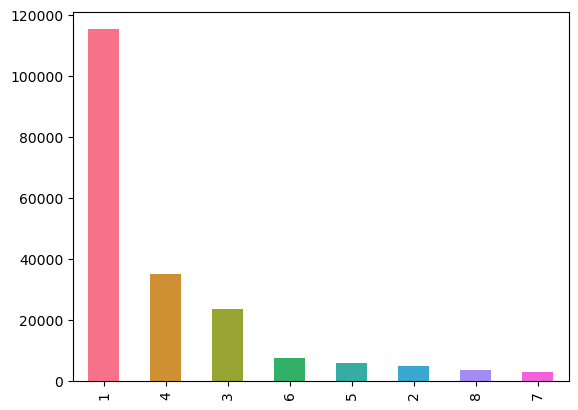

In [13]:
data['action_taken'].value_counts().plot(kind='bar', color=sns.color_palette("husl", 8))

In [14]:
data['derived_dwelling_category'].unique()

array(['Single Family (1-4 Units):Site-Built', 'Multifamily:Site-Built',
       'Single Family (1-4 Units):Manufactured',
       'Multifamily:Manufactured'], dtype=object)

In [15]:
data['occupancy_type'].unique()

array([1, 3, 2], dtype=int64)

In [16]:
data['lien_status'].unique()

array([1, 2], dtype=int64)

In [17]:
data['derived_ethnicity'].unique()

array(['Not Hispanic or Latino', 'Ethnicity Not Available',
       'Hispanic or Latino', 'Joint', 'Free Form Text Only'], dtype=object)

In [18]:
data['applicant_age'].unique()

array(['35-44', '65-74', '25-34', '55-64', '45-54', '<25', '8888', '>74'],
      dtype=object)

In [19]:
data['loan_purpose'].unique()

array([31, 32,  1,  2,  4,  5], dtype=int64)

In [20]:
data['interest_only_payment'].unique()

array([1111,    2,    1], dtype=int64)

In [21]:
# Filter on 1-loan originations, 2-Application approved but not accepted, 8-Preapproval request approved but not accepted,  3-applications denied
df=data[(data['action_taken']==1)|(data['action_taken']==2)|(data['action_taken']==7)|(data['action_taken']==8)|(data['action_taken']==3)]
df.shape

(151032, 99)

### Criteria-based filtering of records

In [22]:
# Filter on singlefamily 1-4 units
df = df[(df['derived_dwelling_category']=='Single Family (1-4 Units):Manufactured') |(data['derived_dwelling_category']=='Single Family (1-4 Units):Site-Built')]

# Filter dfset on occupancy type = 1 - principal residences
df = df[df['occupancy_type']==1]

# Filter dfset on lien_status = 1 - first mortgage loans
df = df[df['lien_status']==1]

# Remove values that don't have a derived_sex = Sex Not Available
df = df[df['derived_sex']!='Sex Not Available']

# Remove values that arent useful 
df = df[df['derived_ethnicity']!='Free Form Text Only']
df = df[df['derived_ethnicity']!='Ethnicity Not Available']

df = df[df['derived_race']!='Free Form Text Only']
df = df[df['derived_race']!='Race Not Available']
#df = df[df['derived_race']!='2 or more minority races']

df = df[df['applicant_age']!='8888']

# Remove Not Applicable values for Loan Purpose
df = df[df['loan_purpose']!=5]

# Remove exempt values for interest_only_payment
df = df[df['interest_only_payment']!=1111]

df = df[df['combined_loan_to_value_ratio']!='Exempt']


Boolean Series key will be reindexed to match DataFrame index.


## 2.2 Transform into Binary Classification Problem
A new column that translates the loan approval or denial decision will be used as the binary target to classify individuals who are identified as approved for a mortgage loan.

In [23]:
# Turn into a binary classification problem
#1 - Loan originated
#2 - Application approved but not accepted
#8 - Preapproval request approved but not accepted
df.loc[df.action_taken == 1, 'action_taken'] = 1
df.loc[df.action_taken == 2, 'action_taken'] = 1
df.loc[df.action_taken == 8, 'action_taken'] = 1

#3 - Application denied
#7 - Preapproval request denied
df.loc[df.action_taken == 3, 'action_taken'] = 0
df.loc[df.action_taken == 7, 'action_taken'] = 0

df['action_taken'].unique()

array([0, 1], dtype=int64)

### 2.3 Outlier Detection and Handling 
Records that were among the top 2% of loan amount values were classified as outliers and removed to balance the dataset. Similarly, records that were among the top 3% and bottom 1% of income levels were classified as outliers and removed.

In [24]:
# Detect outliers by using quantile threshold
print("Top 2% of loan amounts: ",df['loan_amount'].quantile(.98),"\nBottom 1% of income levels: ",df['income'].quantile(.01),"\nTop 3% of income levels: ",df['income'].quantile(.97))

# Remove the top 2% of loan amount values as they are outliers
df = df[(df['loan_amount']<df['loan_amount'].quantile(.98))]

# Remove the top 3% and the bottom 1% of income values as they are outliers
df = df[(df['income']>df['income'].quantile(.01))&(df['income']<df['income'].quantile(.97))]

Top 2% of loan amounts:  665000.0 
Bottom 1% of income levels:  0.0 
Top 3% of income levels:  271.0


# 3. Feature Selection 

In [25]:
pd.set_option('display.max_columns', None)
#data.select_dtypes(include='number')

In [26]:
columns = [
    'income', 
    'debt_to_income_ratio',
    'combined_loan_to_value_ratio',
    'loan_amount',
    'derived_ethnicity', 
    'derived_race', 
    'derived_sex', 
    'applicant_age',
    'preapproval',
    'loan_type',
    'loan_purpose',
    'interest_only_payment',
    'balloon_payment',
    'action_taken',
#Aritra: Additional features to test with XAI based RFE
    'loan_term',
    'property_value',
    'state_code',
    'county_code',
    'tract_minority_population_percent',
    'tract_population',
    'tract_to_msa_income_percentage',
    'tract_median_age_of_housing_units',
    'ffiec_msa_md_median_family_income'
]

df = df[columns]

## 3.1 Mising Values
Check the number of missing values by features selected

<AxesSubplot:>

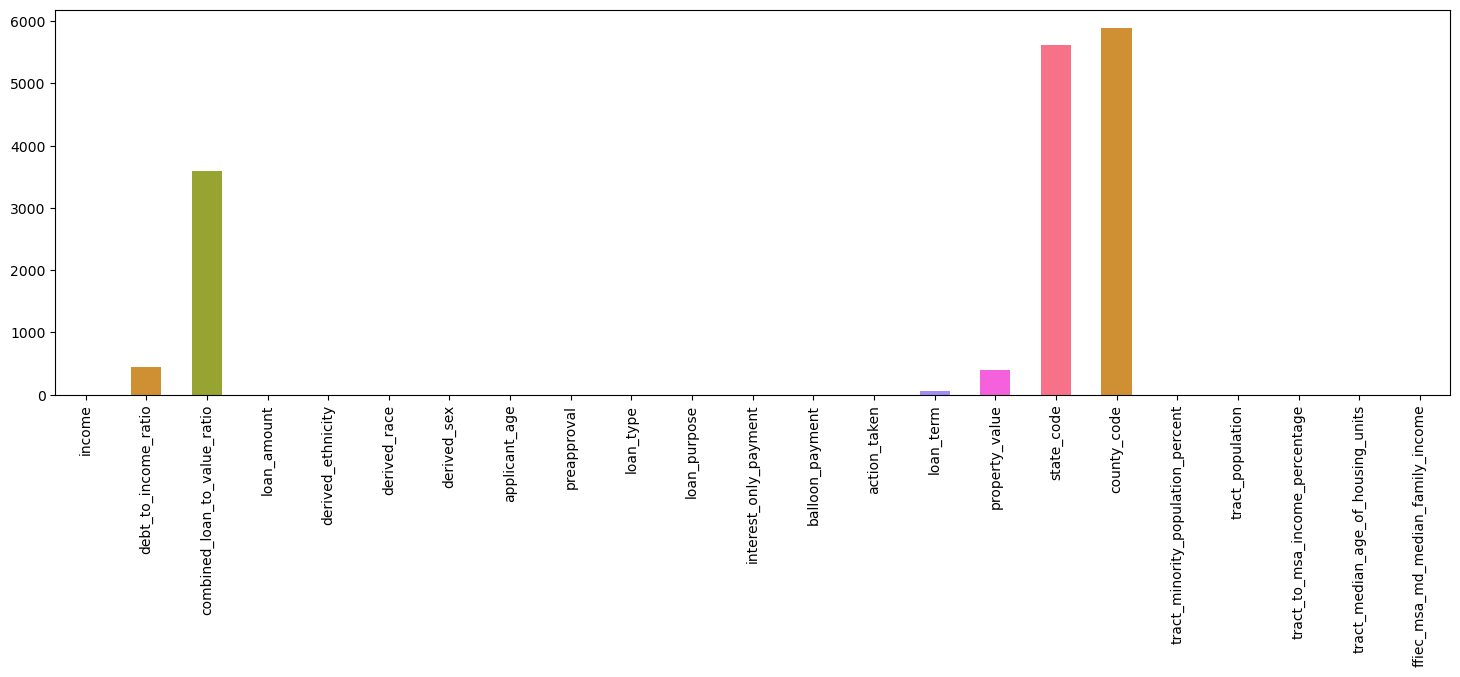

In [27]:
# Visualize missing values 
plt.figure(figsize = (18,5))
df.isnull().sum().plot(kind='bar',color=sns.color_palette("husl", 8))

## 3.2 Drop the rows with null values as they are relatively low occurence

In [28]:
# Drop missing values 
df = df.dropna()
df.shape

(73947, 23)

In [29]:
#df.boxplot(by ='action_taken', column =['income'], grid = False)

#### 3.2.1 Distribution of loan application outcomes by Sex

<AxesSubplot:xlabel='count', ylabel='action_taken'>

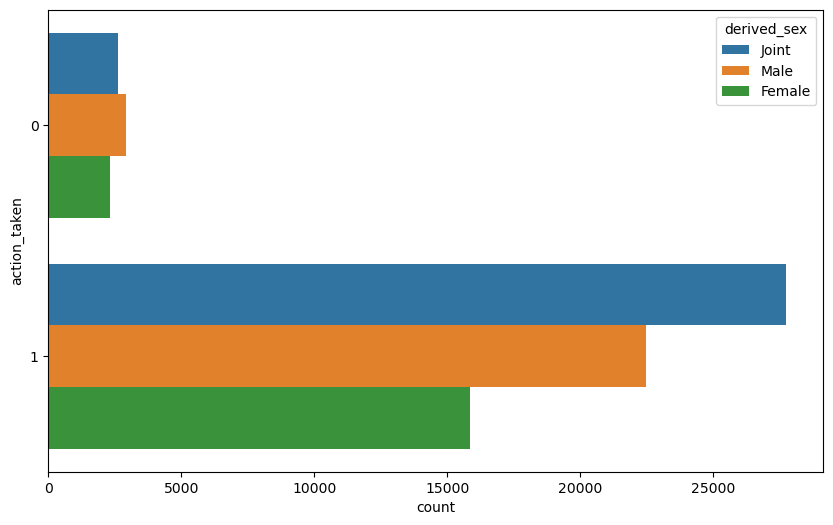

In [30]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, y="action_taken", hue="derived_sex")

#### 3.2.2 Distribution of loan application outcomes by Derived Race

<AxesSubplot:xlabel='count', ylabel='action_taken'>

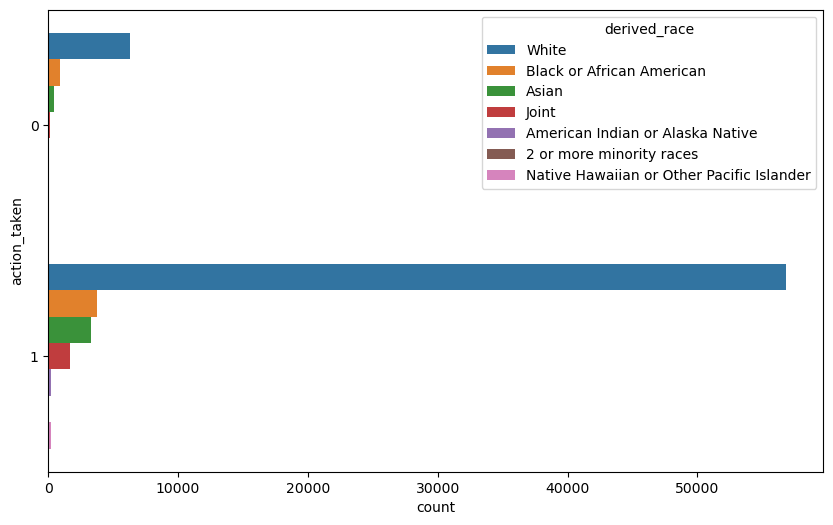

In [31]:
#sns.countplot(data=df, x="action_taken", hue="derived_race")
plt.figure(figsize=(10,6))
sns.countplot(data=df, y="action_taken", hue="derived_race")

#### 3.2.3 Distribution of loan application outcomes by Derived Ethnicity

<AxesSubplot:xlabel='count', ylabel='action_taken'>

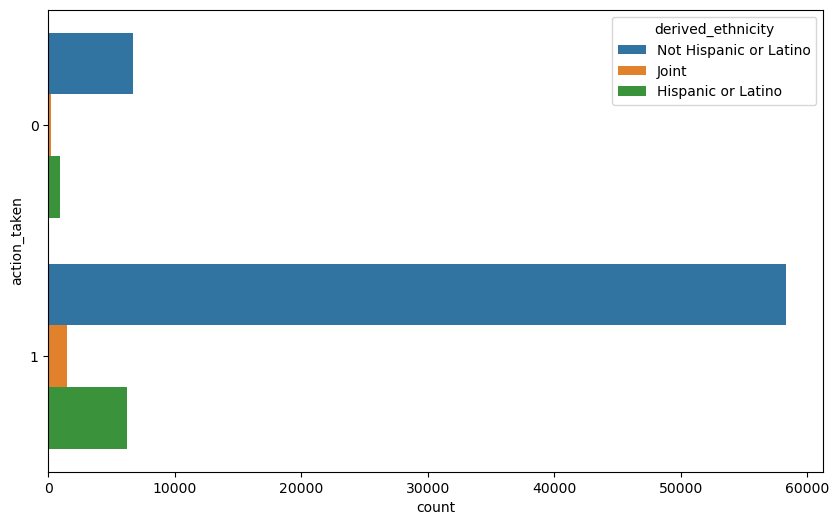

In [32]:
#sns.countplot(data=df, x="action_taken", hue="derived_race")
plt.figure(figsize=(10,6))
sns.countplot(data=df, y="action_taken", hue="derived_ethnicity")

#### 3.2.3 Distribution of loan type outcomes by Income

<AxesSubplot:xlabel='loan_type', ylabel='count'>

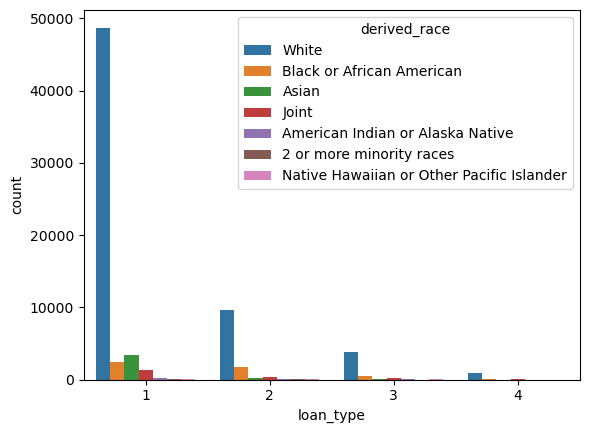

In [33]:
# Taking into account total available values (Setting one person per row):
sns.countplot(x ='loan_type', hue = "derived_race", data = df)

<AxesSubplot:xlabel='loan_type', ylabel='count'>

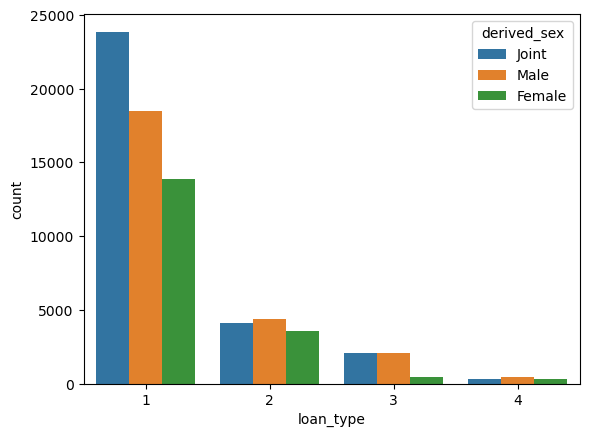

In [34]:
# Taking into account total available values (Setting one person per row):
sns.countplot(x ='loan_type', hue = "derived_sex", data = df)

<AxesSubplot:xlabel='loan_type', ylabel='count'>

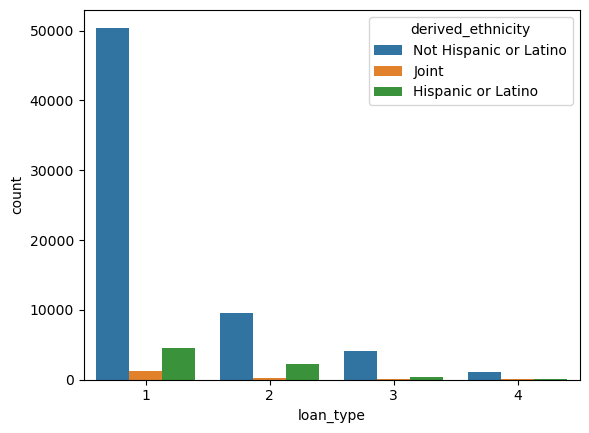

In [35]:
# Taking into account total available values (Setting one person per row):
sns.countplot(x ='loan_type', hue = "derived_ethnicity", data = df)

#### 3.2.4 Distribution of income, sensitive feature and outcome

[Text(0, 0, 'Not Hispanic or Latino'),
 Text(1, 0, 'Joint'),
 Text(2, 0, 'Hispanic or Latino')]

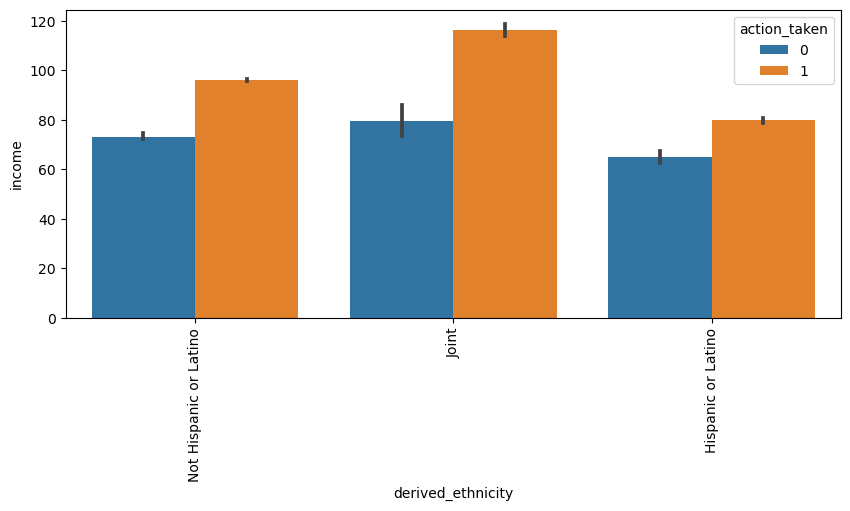

In [36]:
plt.figure(figsize=(10,4))
chart = sns.barplot(
    data=df,
    x="derived_ethnicity", y="income", hue="action_taken"
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

<AxesSubplot:xlabel='derived_sex', ylabel='income'>

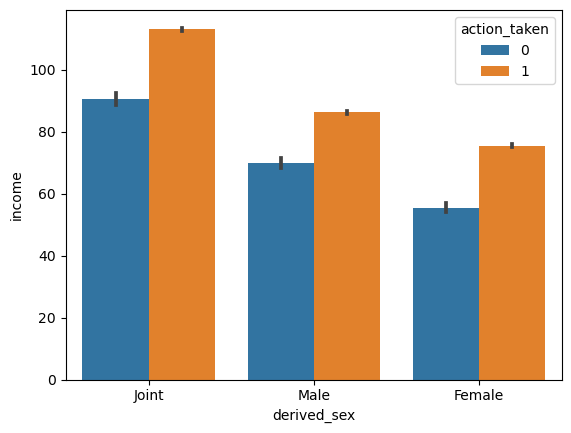

In [37]:
sns.barplot(
    data=df,
    x="derived_sex", y="income", hue="action_taken"
)

[Text(0, 0, 'Joint'), Text(1, 0, 'Male'), Text(2, 0, 'Female')]

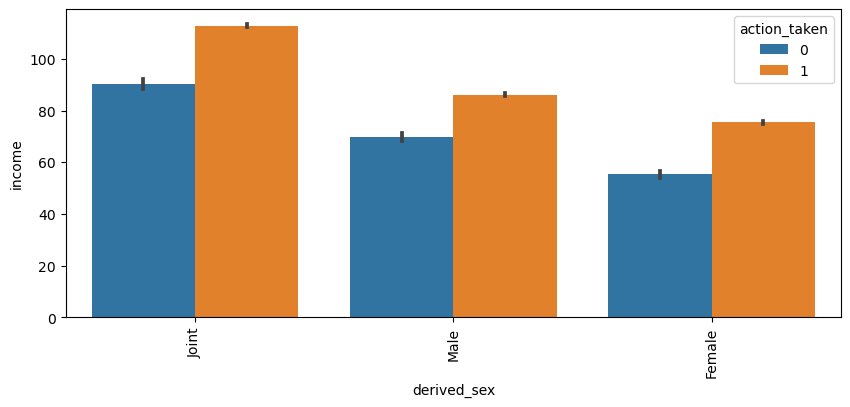

In [38]:
plt.figure(figsize=(10,4))
chart = sns.barplot(
    data=df,
    x="derived_sex", y="income", hue="action_taken"
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

[Text(0, 0, 'White'),
 Text(1, 0, 'Black or African American'),
 Text(2, 0, 'Asian'),
 Text(3, 0, 'Joint'),
 Text(4, 0, 'American Indian or Alaska Native'),
 Text(5, 0, '2 or more minority races'),
 Text(6, 0, 'Native Hawaiian or Other Pacific Islander')]

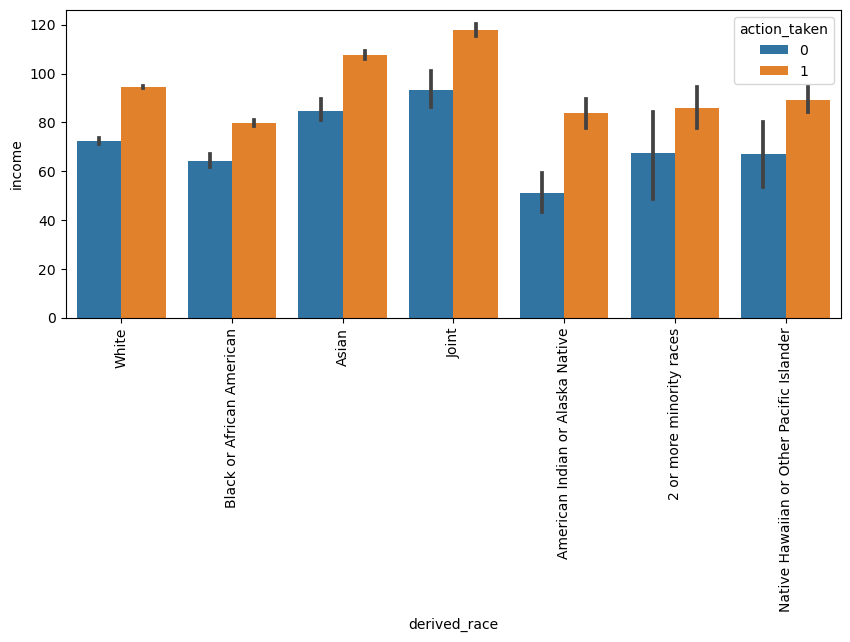

In [39]:
plt.figure(figsize=(10,4))
chart = sns.barplot(
    data=df,
    x="derived_race", y="income", hue="action_taken"
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

#### 3.2.4 Distribution of loan application outcomes by Income

<AxesSubplot:xlabel='action_taken', ylabel='income'>

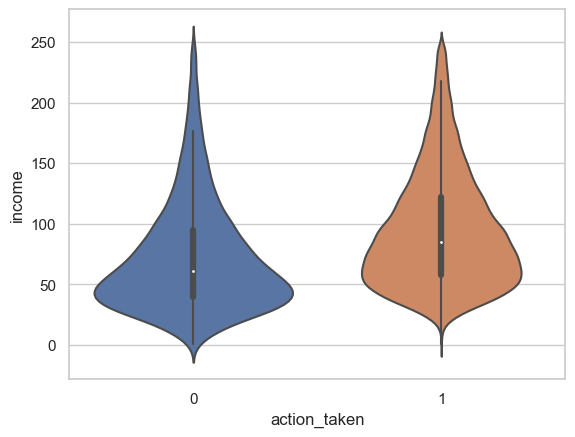

In [40]:
sns.set(style = 'whitegrid') 
sns.violinplot(x ='action_taken', y ='income', data = df)

#### Encode the Derived Ethnicity

In [41]:
encode_ethnicity = {"derived_ethnicity":{"Not Hispanic or Latino": 6, "Hispanic or Latino": 5,"Joint":4}}
df = df.replace(encode_ethnicity)
df.derived_ethnicity.unique()

array([6, 4, 5], dtype=int64)

#### Encode the Derived Race

In [42]:
encode_race = {"derived_race":{"White": 6, "Asian": 5,"Black or African American":4,
               "American Indian or Alaska Native":3,"Native Hawaiian or Other Pacific Islander":2,
              "2 or more minority races":1,"Joint":0}}
df = df.replace(encode_race)
df.derived_race.unique()

array([6, 4, 5, 0, 3, 1, 2], dtype=int64)

#### Encode the Derived Sex

In [43]:
encode_sex = {"derived_sex":{"Female": 2, "Male": 1,"Joint":0}}
df = df.replace(encode_sex)
df.derived_sex.unique()

array([0, 1, 2], dtype=int64)

# 4. Exploratory Data Analysis

In [44]:
df.shape
df.describe()

,income,loan_amount,derived_ethnicity,derived_race,derived_sex,preapproval,loan_type,loan_purpose,interest_only_payment,balloon_payment,action_taken,county_code,tract_minority_population_percent,tract_population,tract_to_msa_income_percentage,tract_median_age_of_housing_units,ffiec_msa_md_median_family_income
count,73947.000000,73947.000000,73947.000000,73947.000000,73947.000000,73947.000000,73947.000000,73947.000000,73947.000000,73947.000000,73947.000000,73947.000000,73947.000000,73947.000000,73947.000000,73947.000000,73947.000000
mean,92.467132,241561.997106,5.857060,5.645259,0.835112,1.915480,1.330696,12.371618,1.988627,1.995930,0.893586,30911.334686,28.350727,5733.928259,113.897589,34.736812,78457.193666
std,47.722018,123521.842328,0.410409,1.089139,0.793372,0.278168,0.658094,14.663283,0.106037,0.063671,0.308369,17107.554325,23.915337,3043.385718,37.641706,17.453661,14613.333654
min,1.000000,5000.000000,4.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1001.000000,0.000000,0.000000,0.000000,0.000000,40600.000000
25%,56.000000,155000.000000,6.000000,6.000000,0.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,12111.000000,10.000000,3933.000000,89.000000,22.000000,69400.000000
50%,83.000000,225000.000000,6.000000,6.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,36029.000000,20.670000,5220.000000,110.000000,32.000000,76700.000000
75%,120.000000,315000.000000,6.000000,6.000000,1.000000,2.000000,1.000000,31.000000,2.000000,2.000000,1.000000,47041.000000,39.670000,6785.500000,135.000000,46.000000,85100.000000
max,248.000000,655000.000000,6.000000,6.000000,2.000000,2.000000,4.000000,32.000000,2.000000,2.000000,1.000000,56041.000000,100.000000,53812.000000,468.000000,76.000000,151000.000000


#### Correlation Matrix

In [45]:
df.corr()

,income,loan_amount,derived_ethnicity,derived_race,derived_sex,preapproval,loan_type,loan_purpose,interest_only_payment,balloon_payment,action_taken,county_code,tract_minority_population_percent,tract_population,tract_to_msa_income_percentage,tract_median_age_of_housing_units,ffiec_msa_md_median_family_income
income,1.000000,0.571377,0.027854,-0.036147,-0.327964,-0.035085,-0.160127,0.142732,-0.033109,0.002731,0.145069,0.010771,-0.071651,0.063917,0.330918,-0.116792,0.215725
loan_amount,0.571377,1.000000,-0.043706,-0.073663,-0.168418,0.074797,-0.014015,0.097996,-0.020620,0.044561,0.133478,-0.100638,0.104352,0.087702,0.251411,-0.156726,0.365983
derived_ethnicity,0.027854,-0.043706,1.000000,0.003703,0.056947,-0.045651,-0.040284,0.027854,-0.022440,-0.017609,0.026201,0.142053,-0.304403,-0.050520,0.089185,-0.000861,0.018245
derived_race,-0.036147,-0.073663,0.003703,1.000000,0.030200,-0.035805,-0.054153,0.005838,-0.013740,-0.017898,0.031590,0.045619,-0.185580,-0.031207,0.036323,0.014008,-0.061509
derived_sex,-0.327964,-0.168418,0.056947,0.030200,1.000000,0.032688,0.004563,-0.045432,0.033810,0.011878,-0.055359,-0.037336,0.102234,-0.036262,-0.109716,0.082659,-0.007980
preapproval,-0.035085,0.074797,-0.045651,-0.035805,0.032688,1.000000,0.104668,0.235640,0.031598,-0.017898,-0.104854,-0.104448,0.126976,0.032932,-0.051681,-0.064747,0.039672
loan_type,-0.160127,-0.014015,-0.040284,-0.054153,0.004563,0.104668,1.000000,-0.181915,0.044983,0.031157,0.010212,-0.070750,0.052893,0.015673,-0.137341,-0.016326,-0.089070
loan_purpose,0.142732,0.097996,0.027854,0.005838,-0.045432,0.235640,-0.181915,1.000000,0.044110,0.010948,-0.064029,-0.070412,0.007331,-0.000416,0.108198,-0.024099,0.101287
interest_only_payment,-0.033109,-0.020620,-0.022440,-0.013740,0.033810,0.031598,0.044983,0.044110,1.000000,0.519941,-0.010957,-0.076634,0.052553,0.015383,-0.008884,-0.003714,-0.002601
balloon_payment,0.002731,0.044561,-0.017609,-0.017898,0.011878,-0.017898,0.031157,0.010948,0.519941,1.000000,-0.003465,-0.064057,0.036869,0.015837,0.002518,-0.015944,0.002686


#### Correlation Plot
This may show us relationships between protected attributes or variables masked as proxies for those protected attribtues.

<AxesSubplot:>

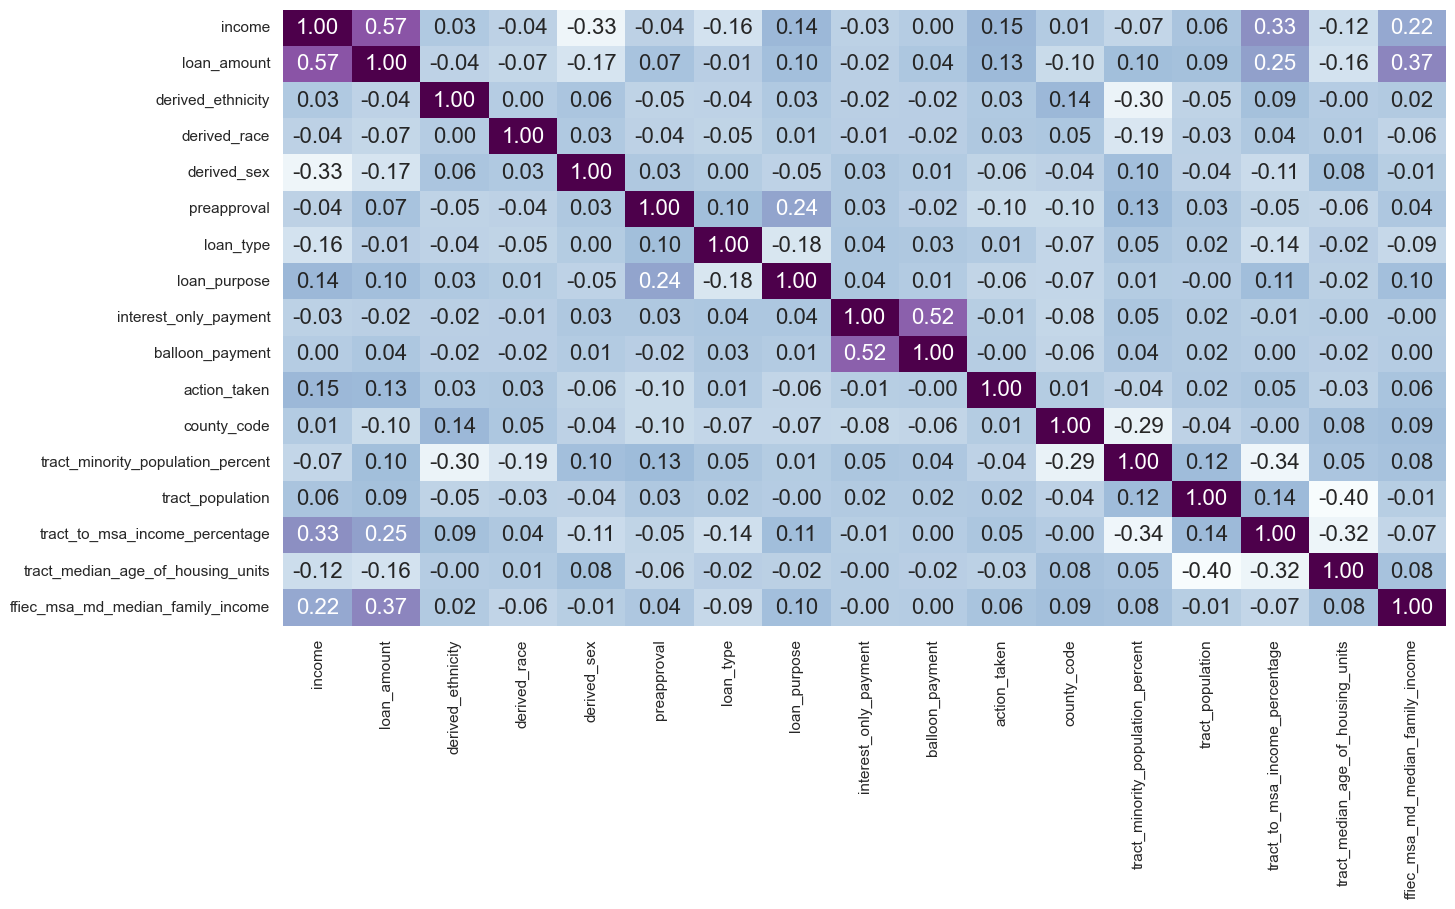

In [46]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(),
           cmap='BuPu',
           annot=True,
           fmt=".2f",
           annot_kws={'size':16},
           cbar=False)

#### Check Correlations among Variables

In [47]:
correlations = df.corr()
correlations.replace(1,0).idxmax()

income                                                     loan_amount
loan_amount                                                     income
derived_ethnicity                                          county_code
derived_race                                               county_code
derived_sex                          tract_minority_population_percent
preapproval                                               loan_purpose
loan_type                                                  preapproval
loan_purpose                                               preapproval
interest_only_payment                                  balloon_payment
balloon_payment                                  interest_only_payment
action_taken                                                    income
county_code                                          derived_ethnicity
tract_minority_population_percent                          preapproval
tract_population                        tract_to_msa_income_percentage
tract_

<AxesSubplot:xlabel='income', ylabel='loan_amount'>

Creating legend with loc="best" can be slow with large amounts of data.


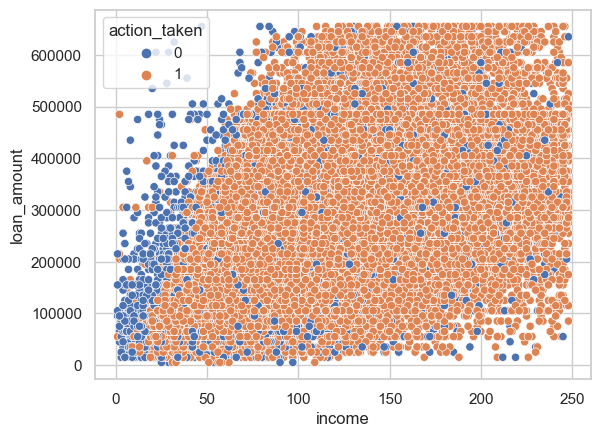

In [48]:
sns.scatterplot(data=df, x="income", y="loan_amount",hue="action_taken")

#### Check for Categorical Variables

In [49]:
cat_cols = df.loc[:,df.dtypes=='object'].columns
for column in cat_cols:
    print('Unique Values in ', column, df[column].unique())
    print(df[column].value_counts())

Unique Values in  debt_to_income_ratio ['30%-<36%' '20%-<30%' '50%-60%' '<20%' '47' '36' '37' '46' '42' '>60%'
 '43' '48' '38' '40' '39' '49' '44' '41' '45']
20%-<30%    17533
30%-<36%    12957
<20%         7689
50%-60%      4193
40           2534
44           2517
39           2363
37           2320
43           2306
38           2297
36           2282
41           2274
42           2254
49           2068
45           1819
48           1703
>60%         1675
47           1588
46           1575
Name: debt_to_income_ratio, dtype: int64
Unique Values in  combined_loan_to_value_ratio ['63.0' '79.0' '87.0' ... 92.059 58.214 35.556]
80.0       4115
80.0       3766
96.5       3394
95.0       3197
96.5       2993
           ... 
79.864        1
67.165        1
84.782        1
101.108       1
35.556        1
Name: combined_loan_to_value_ratio, Length: 24805, dtype: int64
Unique Values in  applicant_age ['35-44' '65-74' '55-64' '>74' '45-54' '25-34' '<25']
25-34    18160
35-44    17711
45-54   

#### Target: Loan Origination 
The target variable, the action taken, is highly imbalanced, with more of the dataset having loan origination outcomes. 

1    66078
0     7869
Name: action_taken, dtype: int64
AxesSubplot(0.125,0.11;0.775x0.77)


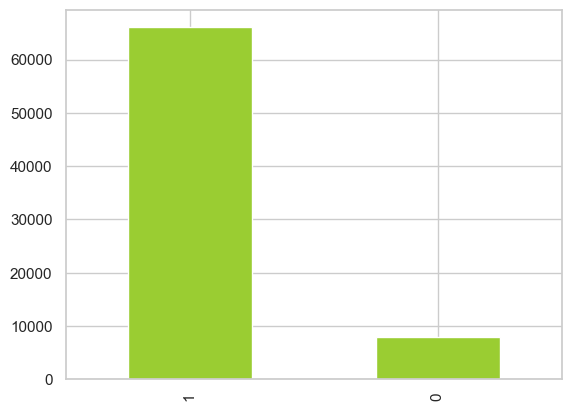

In [50]:
print(df['action_taken'].value_counts())
print(df['action_taken'].value_counts().plot(kind='bar',color="yellowgreen"))

#### Income
The income feature is skewed to the right, with more of the dataset having lower income levels. 

(array([ 229., 1270., 5080., 7914., 8892., 9040., 7517., 6704., 5967.,
        4512., 3775., 3148., 2513., 1861., 1674., 1101.,  975.,  737.,
         554.,  484.]),
 array([  1.  ,  13.35,  25.7 ,  38.05,  50.4 ,  62.75,  75.1 ,  87.45,
         99.8 , 112.15, 124.5 , 136.85, 149.2 , 161.55, 173.9 , 186.25,
        198.6 , 210.95, 223.3 , 235.65, 248.  ]),
 <BarContainer object of 20 artists>)

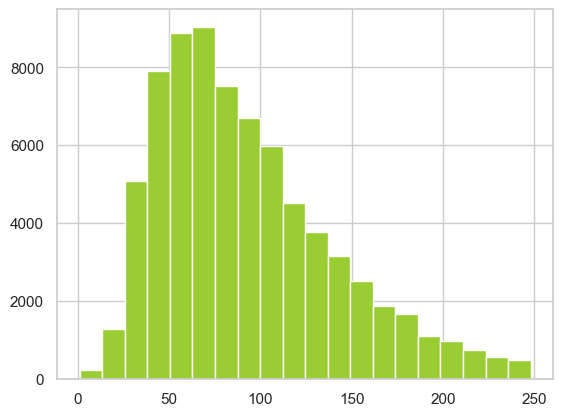

In [51]:
plt.hist(df['income'],bins = 20, color='yellowgreen')

#### Debt to Income Ratio
Bin the debt to income ratio feature 

In [52]:
def getDebtIncomeRatio(var):
    value = 'NaN'
    if (var)=='36':
        value = '36-39'
    elif (var)=='37':
        value = '36-39'
    elif (var)=='38':
        value = '36-39'
    elif (var)=='39':
        value = '36-39'
    elif (var)=='40':
        value = '40-45'
    elif (var)=='41':
        value = '40-45'
    elif (var)=='42':
        value = '40-45'
    elif (var)=='43':
        value = '40-45'
    elif (var)=='44':
        value = '40-45'
    elif (var)=='45':
        value = '40-45'
    elif (var)=='46':
        value = '46-49'   
    elif (var)=='47':
        value = '46-49'  
    elif (var)=='48':
        value = '46-49'  
    elif (var)=='49':
        value = '46-49'  
    else: 
        value = var
    return(value)

In [53]:
df['debt_to_income_ratio'] = df['debt_to_income_ratio'].apply(lambda x: getDebtIncomeRatio(x))
df['debt_to_income_ratio'].value_counts()

20%-<30%    17533
40-45       13704
30%-<36%    12957
36-39        9262
<20%         7689
46-49        6934
50%-60%      4193
>60%         1675
Name: debt_to_income_ratio, dtype: int64

#### Loan to Value Ratio
The loan to value ratio feature is skewed to the right, with more of the dataset having lower debt to income ratios. 

(array([1006., 2746., 3979., 6369., 9775., 7150., 7689., 6610., 7350.,
        4771., 3718., 3054., 3299., 1966., 2020.,  578.,  678.,  456.,
         348.,  385.]),
 array([  5000.,  37500.,  70000., 102500., 135000., 167500., 200000.,
        232500., 265000., 297500., 330000., 362500., 395000., 427500.,
        460000., 492500., 525000., 557500., 590000., 622500., 655000.]),
 <BarContainer object of 20 artists>)

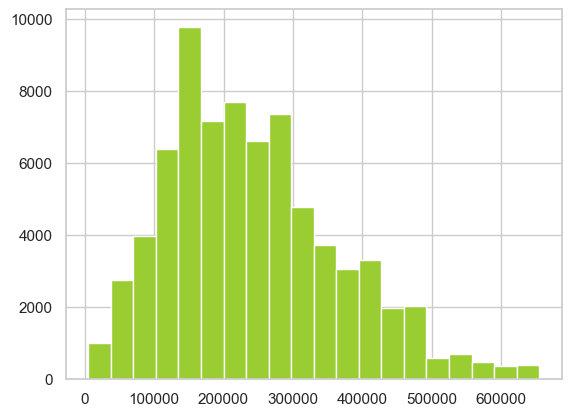

In [54]:
plt.hist(df['loan_amount'],bins = 20, color='yellowgreen')

#### Protected Classes

In [55]:
protectedClassCols = ['derived_ethnicity',
 'derived_race',
 'derived_sex']
 #'applicant_age']

#### Ethnicity Categories
After filtering the dataset, the ethnicity break down: 

AxesSubplot(0.125,0.11;0.775x0.77)


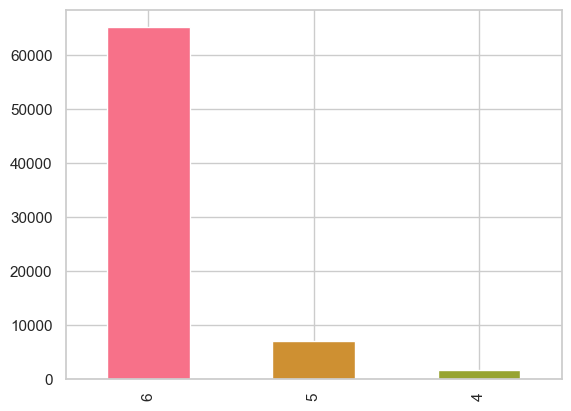

In [56]:
df['derived_ethnicity'].value_counts(normalize = True)
print(df['derived_ethnicity'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Race Categories
After filtering the dataset, the race demographic groups break down: 

AxesSubplot(0.125,0.11;0.775x0.77)


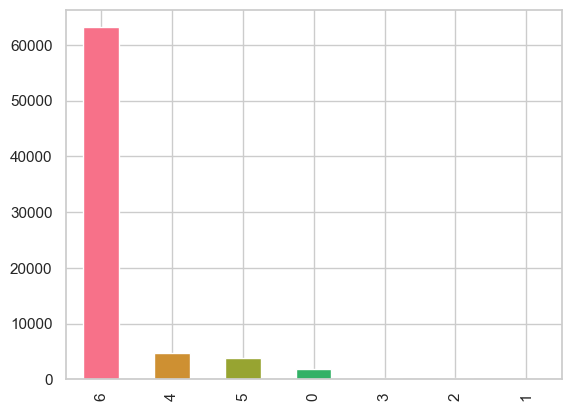

In [57]:
df['derived_race'].value_counts(normalize = True)
print(df['derived_race'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Sex Categories
After filtering the dataset, the sex categories break down: 

AxesSubplot(0.125,0.11;0.775x0.77)


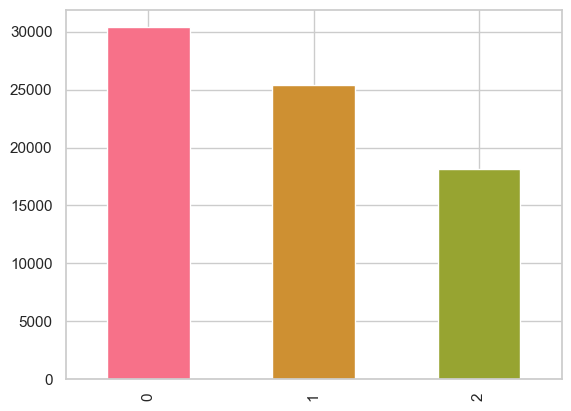

In [58]:
### df['derived_sex'].value_counts(normalize = True)
print(df['derived_sex'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Age
After filtering the dataset, the age groups break down: 

AxesSubplot(0.125,0.11;0.775x0.77)


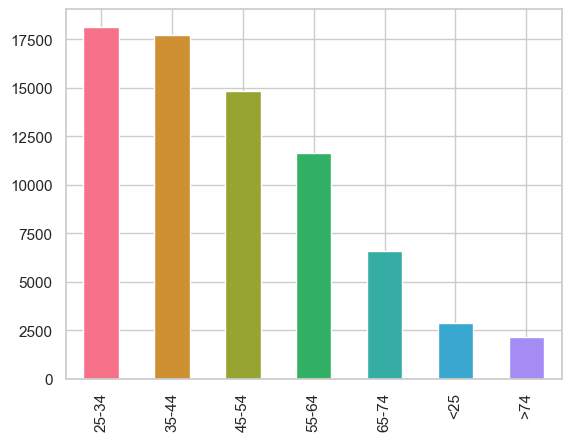

In [59]:
df['applicant_age'].value_counts(normalize = True)
print(df['applicant_age'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

<AxesSubplot:xlabel='count', ylabel='loan_type'>

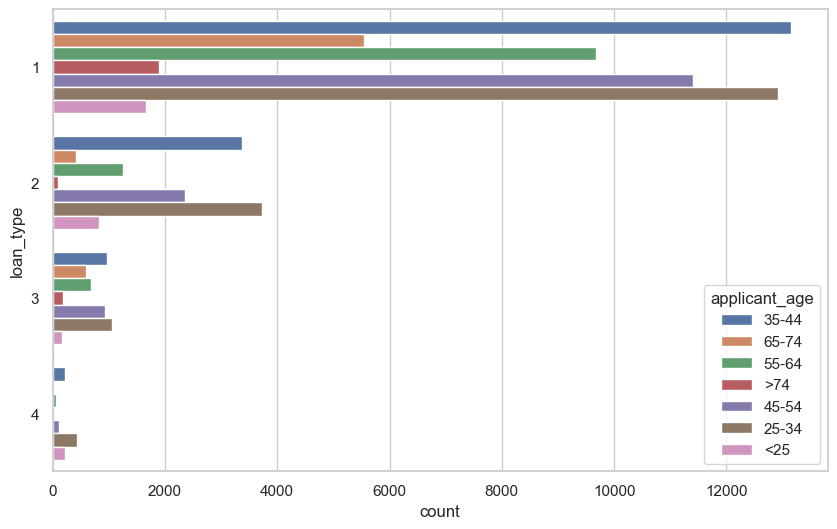

In [60]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, y="loan_type", hue="applicant_age")

<AxesSubplot:xlabel='count', ylabel='action_taken'>

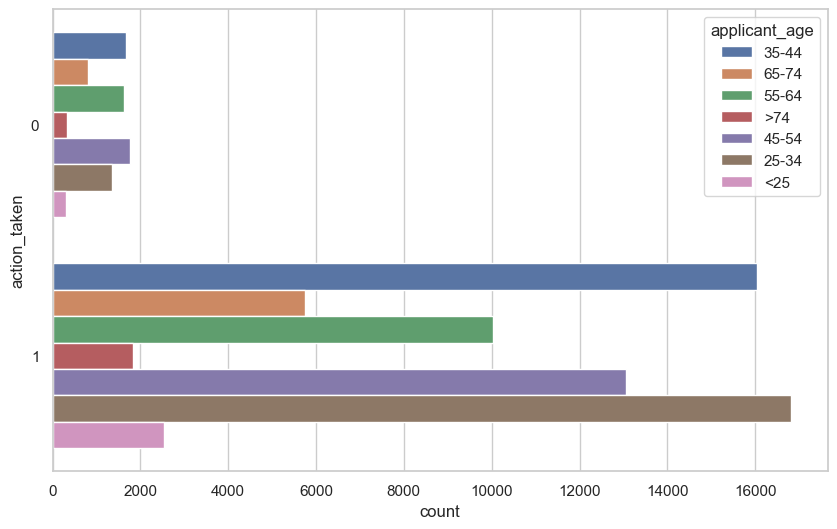

In [61]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, y="action_taken", hue="applicant_age")

#### Loan Type 
After filtering the dataset, the loan types break down: 

AxesSubplot(0.125,0.11;0.775x0.77)


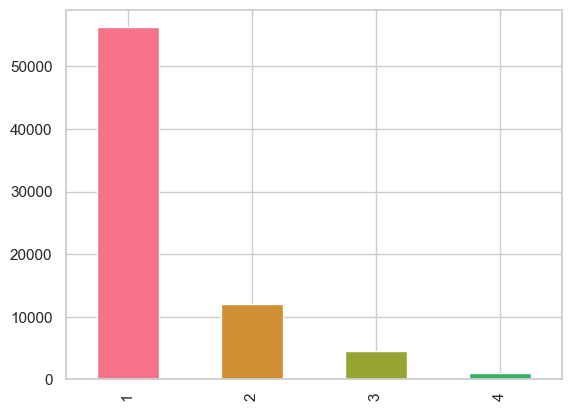

In [62]:
df['loan_type'].value_counts(normalize = True)
print(df['loan_type'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Loan Purpose 
After filtering the dataset, the loan_purpose groups break down: 

AxesSubplot(0.125,0.11;0.775x0.77)


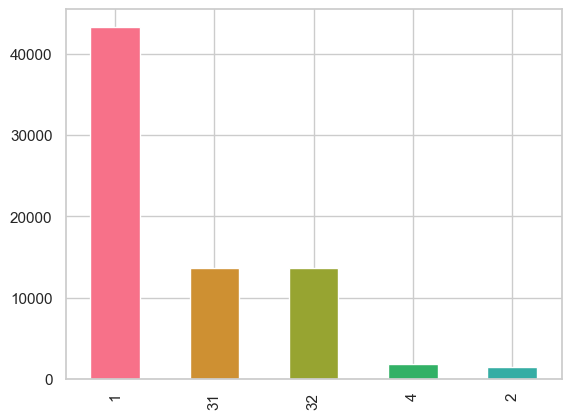

In [63]:
df['loan_purpose'].value_counts(normalize = True)
print(df['loan_purpose'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Interest Only Payments
After filtering the dataset, the interest only payment indicator break down: 

AxesSubplot(0.125,0.11;0.775x0.77)


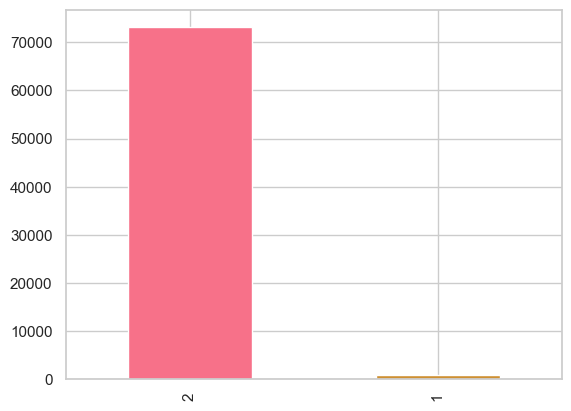

In [64]:
df['interest_only_payment'].value_counts(normalize = True)
print(df['interest_only_payment'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

#### Balloon Payment Indicator
After filtering the dataset, the balloon payment indicator break down:

AxesSubplot(0.125,0.11;0.775x0.77)


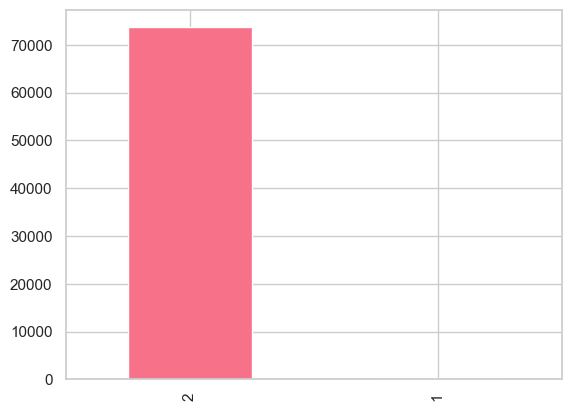

In [65]:
df['balloon_payment'].value_counts()
print(df['balloon_payment'].value_counts().plot(kind='bar',color=sns.color_palette("husl", 8)))

# 5. Data Preparation 

#### Map values in place
Mapping values in place is used instead of one hot encoding to perform the fairness assessment using IBM's AIF360 package.

##### Derived Ethnicity
- 0: Ethnicity Not Available
- 1: Hispanic or Latino 
- 2: Joint
- 3: Not Hispanic or Latino

##### Derived Race
- 0: Race not Available
- 1: 
- 2: Asian ?
- 3: Black or African American
- 4: Joint
- 5: 
- 6: Race not Available ?
- 7: White

##### Derived Sex
- 0: Female
- 1: Joint
- 2: Male
- 3: Sex not Available 

##### Derived Age
- 0: 25-34
- 1: 35-44?
- 2: 45-54?
- 3: 55-64
- 4: 65-74
- 5: <25?
- 6: >74

##### Debt to Income Ratio 
- 0: 20-30
- 1: 30-36
- 2: 36-39
- 3: 40-45
- 4: 46-49
- 5: 50-60

In [66]:
#df['derived_ethnicity'] = df.derived_ethnicity.astype("category").cat.codes
#df['derived_race'] = df.derived_race.astype("category").cat.codes
#df['derived_sex'] = df.derived_sex.astype("category").cat.codes
df['applicant_age'] = df.applicant_age.astype("category").cat.codes
df['debt_to_income_ratio'] = df.debt_to_income_ratio.astype('category').cat.codes
df['combined_loan_to_value_ratio'] = pd.to_numeric(df['combined_loan_to_value_ratio'])
states = pd.DataFrame(df.state_code.unique(), columns = ['state_code'])
states = states.dropna()
states['state_code_id'] = range(1, len(states) +1)
state_codes = dict(zip(states.state_code, states.state_code_id))
df['state_code'] = df['state_code'].map(state_codes)

In [67]:
df.derived_race.unique()

array([6, 4, 5, 0, 3, 1, 2], dtype=int64)

In [68]:
df.dtypes

income                               float64
debt_to_income_ratio                    int8
combined_loan_to_value_ratio         float64
loan_amount                            int64
derived_ethnicity                      int64
derived_race                           int64
derived_sex                            int64
applicant_age                           int8
preapproval                            int64
loan_type                              int64
loan_purpose                           int64
interest_only_payment                  int64
balloon_payment                        int64
action_taken                           int64
loan_term                             object
property_value                        object
state_code                             int64
county_code                          float64
tract_minority_population_percent    float64
tract_population                       int64
tract_to_msa_income_percentage       float64
tract_median_age_of_housing_units      int64
ffiec_msa_

In [69]:
df['debt_to_income_ratio'] = df['debt_to_income_ratio'].astype('float64')
df.astype({'combined_loan_to_value_ratio': 'float64'}).dtypes
df['derived_ethnicity'] = df['derived_ethnicity'].astype('int64')
df['derived_race'] = df['derived_race'].astype('int64')
df['derived_sex'] = df['derived_sex'].astype('int64')
df['applicant_age'] = df['applicant_age'].astype('int64')
df['loan_term'] = df['loan_term'].astype('int64')
df['property_value'] = df['property_value'].astype('float64')
df.astype({'state_code': 'int64'}).dtypes

income                               float64
debt_to_income_ratio                 float64
combined_loan_to_value_ratio         float64
loan_amount                            int64
derived_ethnicity                      int64
derived_race                           int64
derived_sex                            int64
applicant_age                          int64
preapproval                            int64
loan_type                              int64
loan_purpose                           int64
interest_only_payment                  int64
balloon_payment                        int64
action_taken                           int64
loan_term                              int64
property_value                       float64
state_code                             int64
county_code                          float64
tract_minority_population_percent    float64
tract_population                       int64
tract_to_msa_income_percentage       float64
tract_median_age_of_housing_units      int64
ffiec_msa_

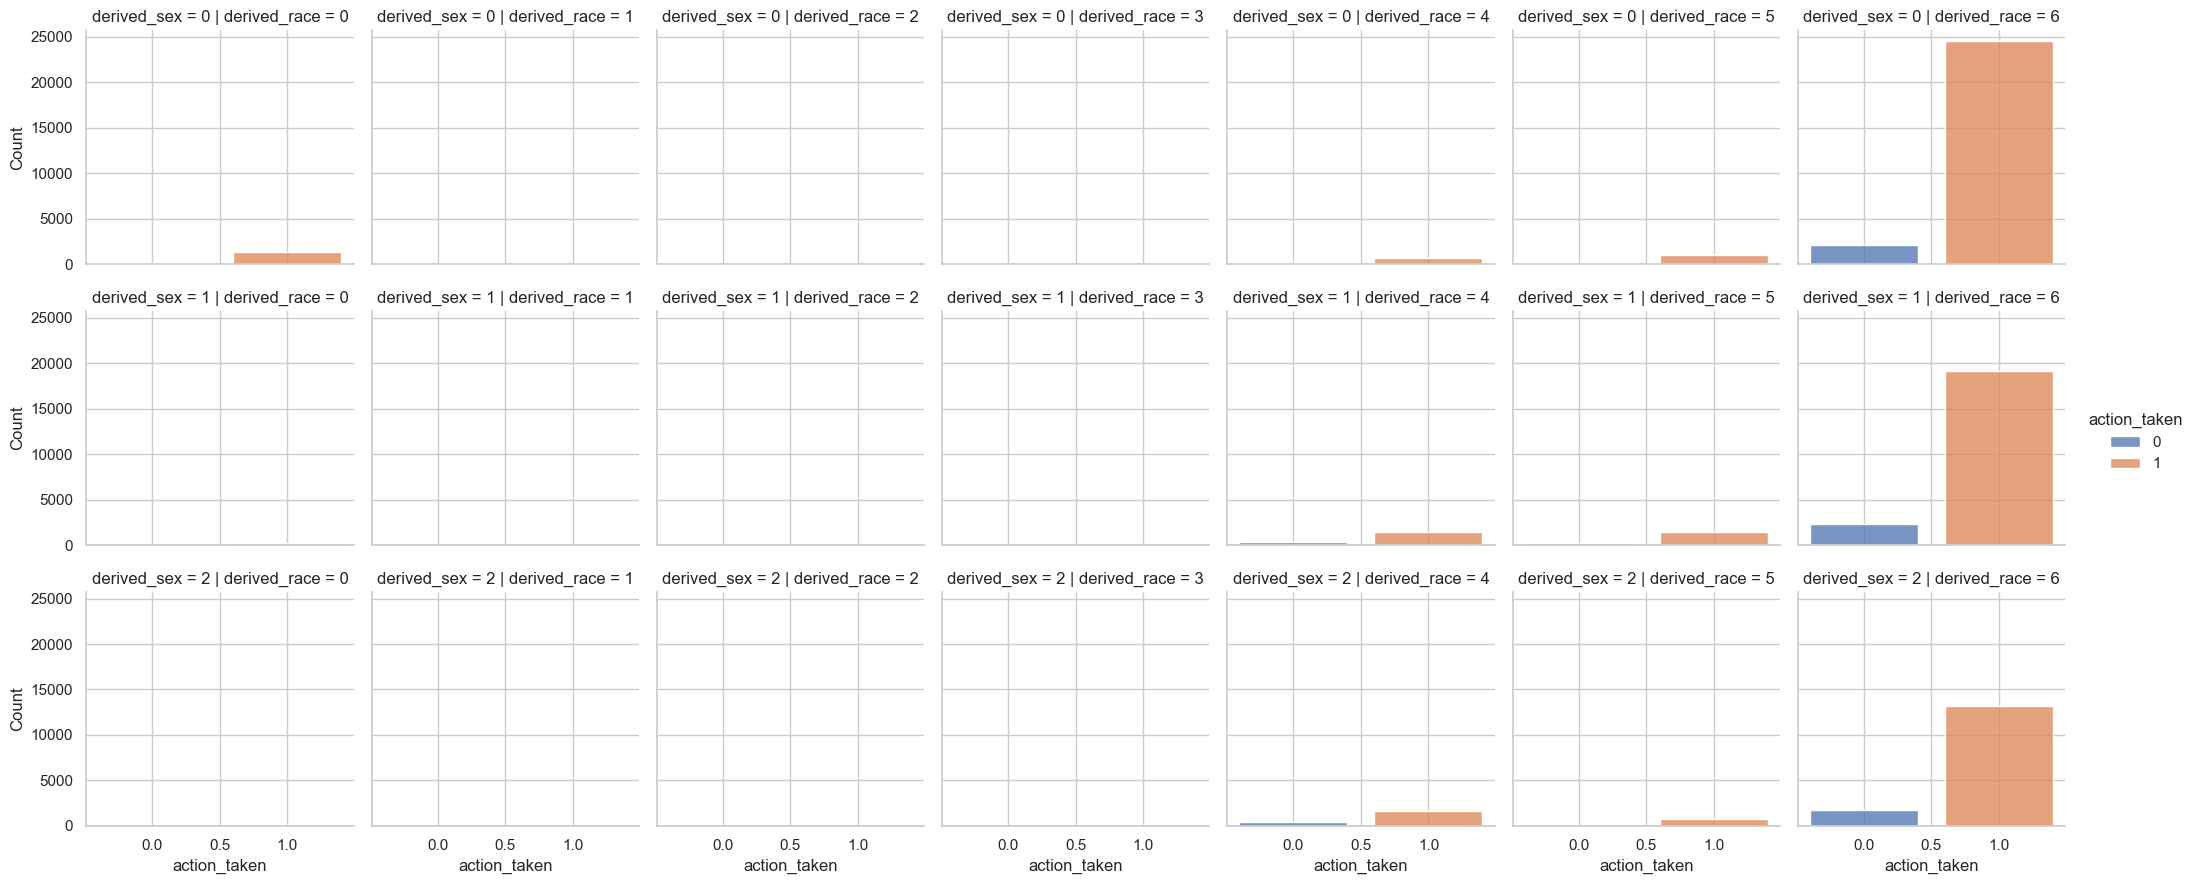

In [70]:
m = sns.FacetGrid(df, row = "derived_sex", col = "derived_race", hue = "action_taken")
m.map(sns.histplot, "action_taken", discrete = True, shrink = .8)
m.add_legend()
plt.show()

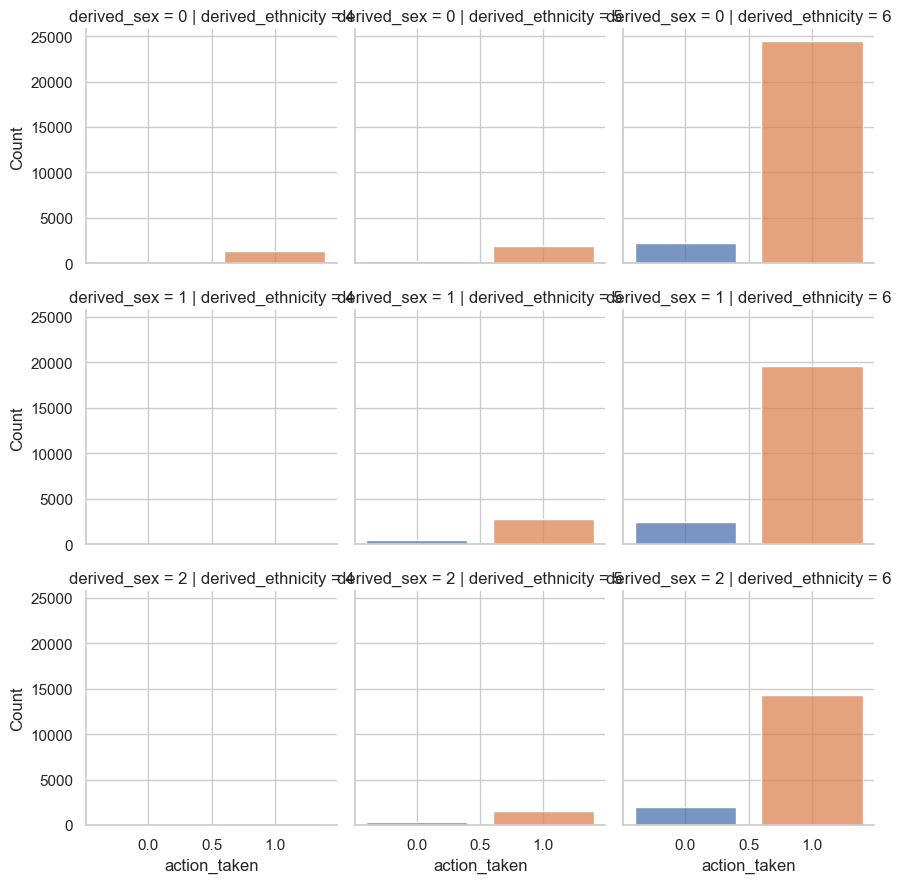

In [71]:
n = sns.FacetGrid(df, row = "derived_sex", col = "derived_ethnicity", hue = "action_taken")
n.map(sns.histplot, "action_taken", discrete = True, shrink = .8)

## Combine sensitive feature groups

In [72]:
df.derived_race.unique()

array([6, 4, 5, 0, 3, 1, 2], dtype=int64)

In [73]:
#df.loc[df.derived_race == 0, 'derived_race'] = 0

In [74]:
#{"derived_race":{"White": 6, "Asian": 5,"Black or African American":4,
#               "American Indian or Alaska Native":3,"Native Hawaiian or Other Pacific Islander":2,
#              "2 or more minority races":1,"Joint":0}}	
df.loc[df.derived_race == 1, 'derived_race'] = 0
df.loc[df.derived_race == 6, 'derived_race'] = 1 #White privileged
df.loc[df.derived_race == 5, 'derived_race'] = 0
df.loc[df.derived_race == 4, 'derived_race'] = 0
df.loc[df.derived_race == 3, 'derived_race'] = 0
df.loc[df.derived_race == 2, 'derived_race'] = 0
df.loc[df.derived_race == 0, 'derived_race'] = 0

# 6. Split the Dataset into Training and Testing Sets
In this section I will define the target variable and features,split data into 70/30 segments.

In [129]:
df.to_csv('hmda_mortgage_derived_race_ffs.csv', index=False)

In [3]:
df = pd.read_csv('hmda_mortgage_derived_race_ffs.csv')

In [4]:
# Define target and features
target = df['action_taken']
features = df.drop(['action_taken'], axis=1)

### Only pick features that result from applying RFECV

#### 10 Features

In [107]:
# Predict using test set
#Test
features = features[['derived_race','debt_to_income_ratio', 'loan_type', 'property_value', 
                                         'state_code', 'combined_loan_to_value_ratio', 
                                         'county_code', 'preapproval', 'loan_amount', 'loan_purpose', 'income']]

#### 15 Features

In [5]:
features = features[['tract_minority_population_percent', 'loan_type', 'income', 'county_code', 
                     'loan_term', 'derived_race', 'ffiec_msa_md_median_family_income', 'loan_amount',
                     'applicant_age', 'debt_to_income_ratio', 'property_value', 'combined_loan_to_value_ratio',
                     'preapproval', 'loan_purpose', 'state_code']]

In [6]:
features.columns

Index(['tract_minority_population_percent', 'loan_type', 'income',
       'county_code', 'loan_term', 'derived_race',
       'ffiec_msa_md_median_family_income', 'loan_amount', 'applicant_age',
       'debt_to_income_ratio', 'property_value',
       'combined_loan_to_value_ratio', 'preapproval', 'loan_purpose',
       'state_code'],
      dtype='object')

In [7]:
# Split into train/test while maintaining stratification to maintain class balance
#X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(features,target, train_size=0.8)

valid_size=0.5 #(that is 50% of remaining data)
#test_size = 0.2
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.2)


print('Number of data points in train data:', X_train.shape)
print('Number of data points in test data:', X_test.shape)

Number of data points in train data: (59157, 15)
Number of data points in test data: (2958, 15)


### DO ONLY WHEN PROTECTED FEATURE NOT IN TRAINING SET

In [109]:
protected_attribute = X_test['derived_race']
X_valid = X_valid.drop(['derived_race'], axis=1)
X_train = X_train.drop(['derived_race'], axis=1)
X_test = X_test.drop(['derived_race'], axis=1)

In [110]:
X_train.columns

Index(['debt_to_income_ratio', 'loan_type', 'property_value', 'state_code',
       'combined_loan_to_value_ratio', 'county_code', 'preapproval',
       'loan_amount', 'loan_purpose', 'income'],
      dtype='object')

In [111]:
X_test.columns

Index(['debt_to_income_ratio', 'loan_type', 'property_value', 'state_code',
       'combined_loan_to_value_ratio', 'county_code', 'preapproval',
       'loan_amount', 'loan_purpose', 'income'],
      dtype='object')

## 8.0 Model Training

In [8]:
# Fit final model with best params obtained from the RFECV
#{'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 0.5, 'max_depth': 5, 'colsample_bylevel': 0.5}
#res_x_clf = XGBClassifier(colsample_bylevel= 0.5, colsample_bytree= 1.0, gamma= 0.0, learning_rate= 0.1, max_depth= 5, 
#                      min_child_weight= 0.5, n_estimators= 200, objective= 'binary:logistic', reg_alpha= 0.1, 
#                      reg_lambda= 1.0, silent= False, subsample= 1.0, eval_metrics='auc',random_state=42)

res_x_clf = RandomForestClassifier(random_state=42)

res_x_clf.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

## 9 Cross-Validation

In [113]:
k_folds = KFold(n_splits = 5)

scores = cross_val_score(res_x_clf, X_valid, y_valid, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Before check_cv
Before parallel = Parallel(n_jobs=n_jobs, verbose=verbose, pre_dispatch=pre_dispatch)
After parallel = Parallel(n_jobs=n_jobs, verbose=verbose, pre_dispatch=pre_dispatch)
Before callable(scoring)
Cross Validation Scores:  [0.91550486 0.91930714 0.92349958 0.91631445 0.91885038]
Average CV Score:  0.9186952821641328
Number of CV Scores used in Average:  5


## 10. Model Predictions

In [9]:
# Predict using test set
#Test
y_pred = res_x_clf.predict(X_test)
y_pred_proba = res_x_clf.predict_proba(X_test)[:,1]

In [10]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

Best Threshold=0.893333, G-Mean=0.746


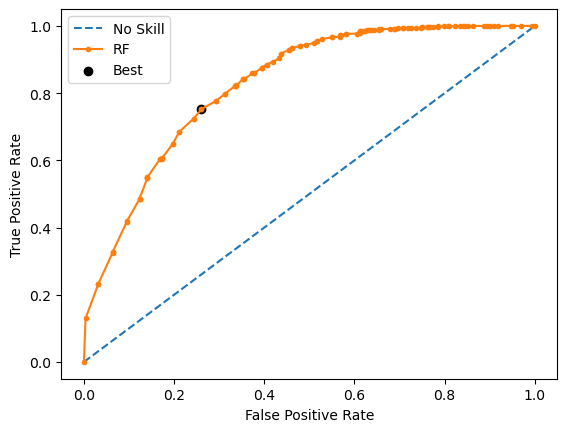

In [11]:
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='RF')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.610000, F-Score=0.962


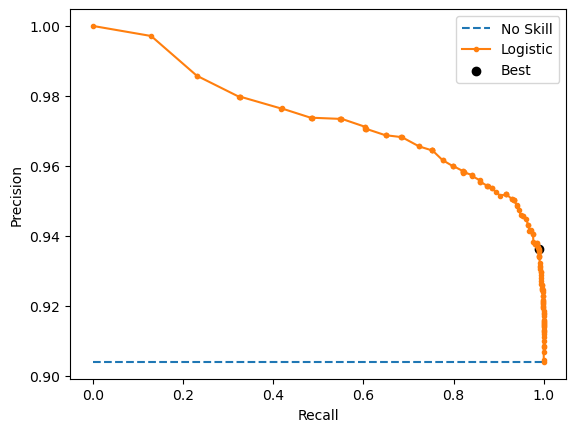

In [12]:
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [13]:
#Applying threshold from ROC 
threshold = 0.89
y_pred = (res_x_clf.predict_proba(X_test)[:, 1] > threshold).astype('float')

# 9. Model Evaluation Metrics

In [142]:
# Create classification model eval method
def model_eval(y, prediction): 
    """
    Method to calculate model evaluation metrics to measure the effectiveness of the model. 
    
    :param y (numpy array): Train or test target values for ML model
    :param prediction (numpy array): Predictions from the ML model
    """
    accuracy = round(metrics.accuracy_score(y, prediction), 4)
    recall_sensitivity = round(metrics.recall_score(y, prediction), 4)
    recall_specificity = round(metrics.recall_score(y, prediction, pos_label=0), 4)
    precision_positive = round(metrics.precision_score(y, prediction), 4)
    precision_negative = round(metrics.precision_score(y, prediction, pos_label=0), 4)
    positive_f1_score = round(metrics.f1_score(y, prediction), 4)
    negative_f1_score = round(metrics.f1_score(y, prediction, pos_label=0), 4)
    
    model_eval_metrics = {'Accuracy': accuracy,
              'Sensitivity': recall_sensitivity,
              'Specificity': recall_specificity,
              'Precision Positive': precision_positive,
              'Precision Negative': precision_negative,
              'F1 Score Positive': positive_f1_score,
              'F1 Score Negative': negative_f1_score}
    
    return(model_eval_metrics)

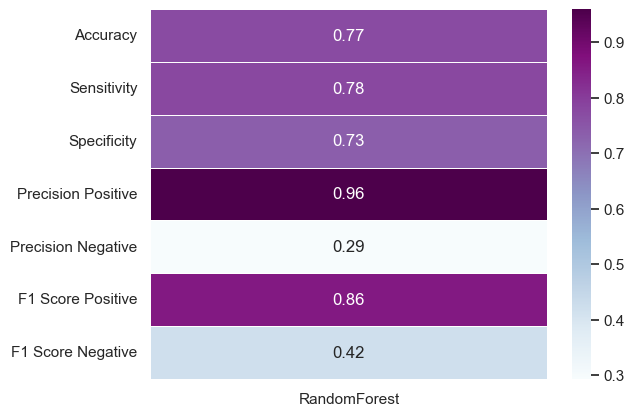

In [143]:
# Call model evaluation metrics
#x_results = model_eval(y_test, x_pred)
rf_results = model_eval(y_test, y_pred)

# Visualize model evaluation metrics in a heatmap 
#xgbmodel = x_results
rfmodel = rf_results

#viz = pd.DataFrame.from_dict(xgbmodel, orient='index', columns=['XGBoost'])
viz = pd.DataFrame.from_dict(rfmodel, orient='index', columns=['RandomForest'])
viz['RandomForest'] = pd.DataFrame.from_dict(rfmodel, orient='index', columns=['RandomForest'])

viz.head(10)
ax = sns.heatmap(viz,
                cmap = 'BuPu',
                linewidths = .5,
                annot = True)

### Preparing test data for AIF360

In [144]:
# Construct the test dataframe
test_df = pd.DataFrame(X_test)
test_df['derived_race'] = protected_attribute
test_df['action_taken'] = y_test

# Convert the test dataframe into a BinaryLabelDataset
bld_df = BinaryLabelDataset(favorable_label=1,
                            unfavorable_label=0,
                            df=test_df,
                            label_names=['action_taken'],
                            #protected_attribute_names=['derived_race','derived_sex','derived_ethnicity'])
                            protected_attribute_names=['derived_race'])


# Copy the test BinaryLabelDataset format and add the logistic regression predictions 
bld_df_pred = bld_df.copy()
bld_df_pred.labels = y_pred

In [145]:
# Initialize the unprivileged and privileged groups
#unprivileged_groups = [{'derived_race':1}] # African American 
#privileged_groups = [{'derived_race':2}] # Caucasian  

unprivileged_groups = [{'derived_race':0}] #  
privileged_groups = [{'derived_race':1}] # 

# Create the ClassificationMetric that will be used in fairness assessment 
clf_metric = ClassificationMetric(bld_df,
                                  bld_df_pred,
                                  unprivileged_groups,
                                  privileged_groups)

## Fairness Assessment

In [123]:
def fairness_bias_detection(clf_metric):    
    metrics = {"Accuracy":clf_metric.accuracy(),
               "Disparate Impact":clf_metric.disparate_impact(),
               "Statistical Parity Difference":clf_metric.statistical_parity_difference(),
               "Equal Opportunity Difference":clf_metric.equal_opportunity_difference(),
               "Average Odds Difference":clf_metric.average_odds_difference(),
               "Theil Index":clf_metric.theil_index(),
               "False Positive Rate":clf_metric.false_positive_rate(),
               "False Negative Rate":clf_metric.false_negative_rate(),
               "False Omission Rate":clf_metric.false_omission_rate(),
               "False Discovery Rate":clf_metric.false_discovery_rate(),
               "Error Rate":clf_metric.error_rate(),
               "Differential Fairness Bias Amplification":clf_metric.differential_fairness_bias_amplification()}
    
    return(metrics)

In [124]:
# Call fairness assessment metrics 
fair_assessment = fairness_bias_detection(clf_metric)

### Calculate fairness metrics

In [125]:
fair_viz = pd.DataFrame.from_dict(fair_assessment, orient='index', columns=['RandomForest Fairness Assessment'])
fair_viz = fair_viz.iloc[0:12]
fair_viz.head(15)

,RandomForest Fairness Assessment
Accuracy,0.796146
Disparate Impact,0.961010
Statistical Parity Difference,-0.029849
Equal Opportunity Difference,-0.005909
Average Odds Difference,-0.020881
Theil Index,0.197884
False Positive Rate,0.340557
False Negative Rate,0.187097
False Omission Rate,0.698300
False Discovery Rate,0.048845


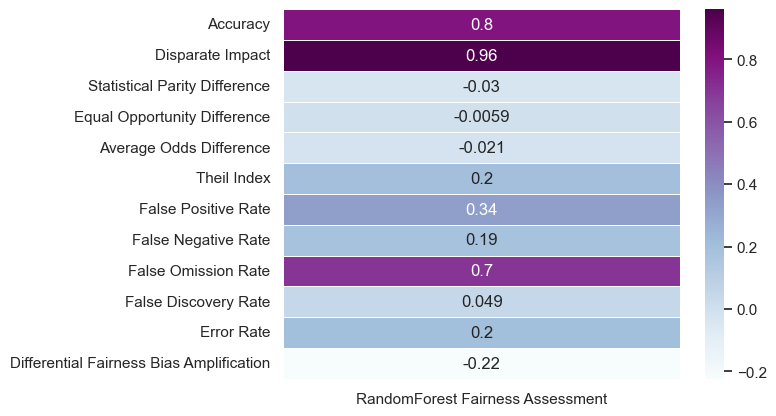

In [127]:
fair_results = sns.heatmap(fair_viz,
                           cmap="BuPu",
                           linewidths=.5,
                           annot=True)

#fair_viz['SMOTE XGBoost Fairness Assessment'] = fair_viz['SMOTE XGBoost Fairness Assessment'].astype(float)

## 9. Explain Model Predictions

In [ ]:
# Explain predictions using the SHAP TreeExplainer
shap.initjs()
explainer = shap.TreeExplainer(res_x_clf)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_train.iloc[:1000,:])

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)